<a href="https://colab.research.google.com/github/DeekshaKarkada/Language-Translation-for-Hi-Kn/blob/main/mT5_Transformer_BM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implemented Language Translation for Hindi and Kannada languages using https://huggingface.co/google/mt5-base as reference**

In [ ]:
! pip install datasets sacrebleu transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import warnings
import numpy as np
import pandas as pd
import datasets
import torch
import transformers
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, MT5Tokenizer, MT5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_metric
from sacrebleu import corpus_bleu

warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to load the text dataset files

def load_data(file_name):
  with open(file_name, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  return lines

src_lines = load_data('/content/drive/MyDrive/Thesis/NLLB_hi_kn-hi.txt')
tgt_lines = load_data('/content/drive/MyDrive/Thesis/NLLB_hi_kn-kn.txt')

dataset = pd.DataFrame({'src': src_lines, 'tgt': tgt_lines})

dataset = dataset.drop_duplicates().sample(frac=0.02).reset_index(drop=True)

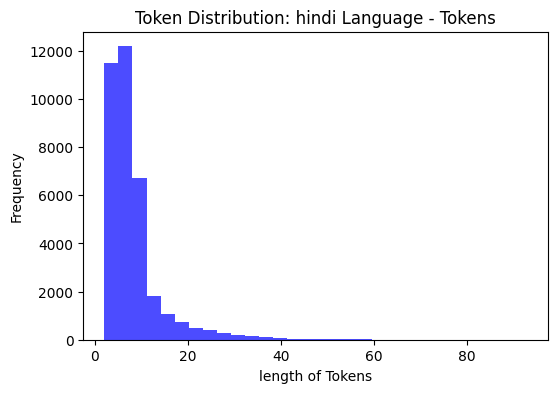

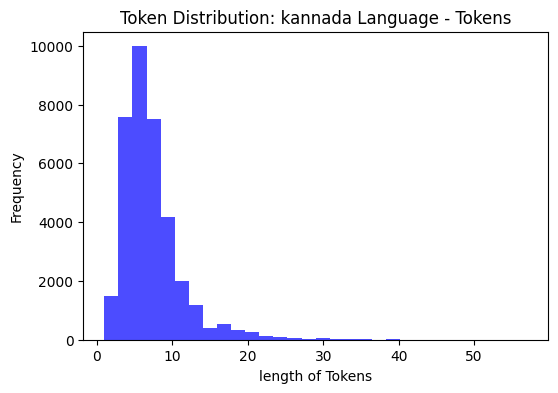

In [ ]:
#Graph to see the token distribution over lenght of the the tokens

import matplotlib.pyplot as plt

def plot_token_distribution(dataset, column, title):
    token_lengths = dataset[column].apply(lambda x: len(x.split()))
    plt.figure(figsize=(6, 4))
    plt.hist(token_lengths, bins=30, alpha=0.7, color='blue')
    plt.title(f'Token Distribution: {title}')
    plt.xlabel('length of Tokens')
    plt.ylabel('Frequency')
    plt.show()

plot_token_distribution(dataset, 'src', 'hindi Language - Tokens')
plot_token_distribution(dataset, 'tgt', 'kannada Language - Tokens')


In [ ]:
# Split the data into training and testing sets
def split_data(dataset):
  train_data, test_data = train_test_split(dataset, test_size=0.25)
  train_data, validation_data = train_test_split(train_data, test_size=0.35)
  return train_data, validation_data, test_data

train_data, validation_data, test_data = split_data(dataset)

# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)

In [ ]:
validation_dataset.shape

(9418, 3)

In [ ]:
# Initialize the tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'google/mt5-base'
tokenizer = MT5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [ ]:
# Function to map the tokenixer inputs to training, testing and valdiation datasets

def preprocess_function(examples):
    inputs = examples["src"]
    targets = examples["tgt"]

    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True, padding="max_length")
    return model_inputs

In [ ]:
train_dataset = train_dataset.map(preprocess_function, batched=True, desc="Running tokenizer on train dataset")
validation_dataset = validation_dataset.map(preprocess_function, batched=True, desc="Running tokenizer on validation dataset")
test_dataset = test_dataset.map(preprocess_function, batched=True, desc="Running tokenizer on test dataset")


Running tokenizer on train dataset:   0%|          | 0/17490 [00:00<?, ? examples/s]

Running tokenizer on validation dataset:   0%|          | 0/9418 [00:00<?, ? examples/s]

Running tokenizer on test dataset:   0%|          | 0/8970 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Save model at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    gradient_accumulation_steps=2,
    warmup_steps=500,
    eval_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define the BLEU metric
bleu_metric = load_metric("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_labels = [[label] for label in decoded_labels]
    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": bleu['score']}

# Initialize the trainer for the initial training phase
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


The repository for sacrebleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sacrebleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
# Train the model initially

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu
0,0.755100,0.479674,1.862077
2,0.520500,0.431744,3.195475


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=6558, training_loss=2.6490040311147323, metrics={'train_runtime': 8169.4215, 'train_samples_per_second': 6.423, 'train_steps_per_second': 0.803, 'total_flos': 1.572549001740288e+16, 'train_loss': 2.6490040311147323, 'epoch': 2.999313972101532})

In [ ]:
import pandas as pd

# Extract the log history
log_history = trainer.state.log_history

# Convert the log history into a DataFrame
metrics_df = pd.DataFrame(log_history)

# Display the DataFrame to understand the structure
metrics_df.head()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_bleu,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,25.6229,213.585770,0.000050,0.228676,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.4385,11.003291,0.000046,0.457352,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.8877,2.992550,0.000042,0.686028,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.7551,0.966338,0.000038,0.914704,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.999771,2186,0.479674,1.862077,1204.91,7.816,1.955,NaN,NaN,NaN,NaN,NaN


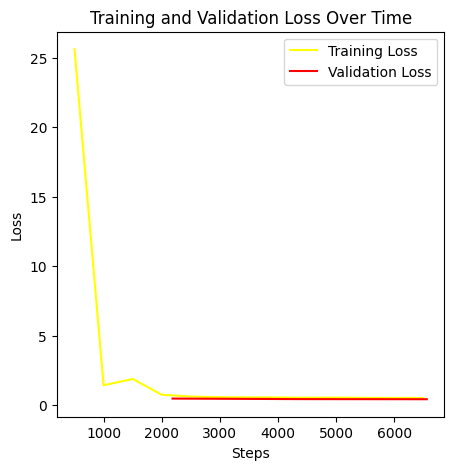

In [ ]:
import matplotlib.pyplot as plt

# Filter out the steps that contain training and evaluation loss
train_loss = metrics_df[metrics_df['loss'].notna()][['step', 'loss']]
eval_loss = metrics_df[metrics_df['eval_loss'].notna()][['step', 'eval_loss']]

# Plot the training loss
plt.figure(figsize=(5, 5))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss', color='yellow')

# Plot the validation loss
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Validation Loss', color='red')

# Add titles and labels
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Evaluate on the test set before fine-tuning
initial_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Initial BLEU score on test set: {initial_results['eval_bleu']}")

# Save the model checkpoint after initial training
trainer.save_model("mt5_model.pt")

Initial BLEU score on test set: 3.1631121112262206


In [ ]:
import sacrebleu

# Generate translations for the test set
def get_score(test_dataset):
  refs = [[ex["tgt"]] for ex in test_dataset]
  preds = [generate_translation(ex["src"]) for ex in test_dataset]
  bleu = sacrebleu.corpus_bleu(preds, refs)
  print(f"Test BLEU score after fine-tuning: {bleu.score}")

In [ ]:
get_score(test_dataset)

Test BLEU score after fine-tuning: 21.02241038134286


Test the translation performance by giving a Hinid phrase as input

In [ ]:
input_text = "यह शुरू करने का समय है"
result = generate_translation(input_text)
print(result)


ಈಗ ಪ್ರಾರಂಭಿಸಲು ಸಮಯ.


**Following the same procedure, to translate text from Kannada to Hindi as well**

In [ ]:
back_dataset = pd.DataFrame({'src': tgt_lines , 'tgt': src_lines}) #Here src-kannada, tgt-hindi

back_dataset = back_dataset.drop_duplicates().sample(frac=0.02).reset_index(drop=True)

In [ ]:
back_dataset.head(3)

,src,tgt
0,ಬಾಲಸಂಸ್ಕಾರ > ಆದರ್ಶ ಮಕ್ಕಳು > ವ್ಯಕ್ತಿತ್ವ ವಿಕಸನ\n,बालसंस्कार > आदर्श बालक\n
1,ವಿ. ವಿಯಲ್ಲಿ ಪ್ರತಿಭಟನೆ\n,फेज V में अपार्टमेंट\n
2,ಈ ಥಿಯರಿಯನ್ನು ಒಪ್ಪದ ಗುಂಪುಃ\n,इन देशों ने प्रस्ताव पर दी अपनी सहमति\n


In [ ]:
rev_train, rev_validation, rev_test = split_data(back_dataset)

rev_train_dataset = Dataset.from_pandas(rev_train)
rev_validation_dataset = Dataset.from_pandas(rev_validation)
rev_test_dataset = Dataset.from_pandas(rev_test)

In [ ]:
rev_train_dataset.shape

(17490, 3)

In [ ]:
rev_train_dataset = rev_train_dataset.map(preprocess_function, batched=True, desc="Running tokenizer on train dataset back translation")
rev_validation_dataset = rev_validation_dataset.map(preprocess_function, batched=True, desc="Running tokenizer on validation dataset back translation")
rev_test_dataset = rev_test_dataset.map(preprocess_function, batched=True, desc="Running tokenizer on test dataset back translation")

Running tokenizer on train dataset back translation:   0%|          | 0/17490 [00:00<?, ? examples/s]

Running tokenizer on validation dataset back translation:   0%|          | 0/9418 [00:00<?, ? examples/s]

Running tokenizer on test dataset back translation:   0%|          | 0/8970 [00:00<?, ? examples/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Save model at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    gradient_accumulation_steps=2,
    warmup_steps=500,
    eval_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define the BLEU metric
bleu_metric = load_metric("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_labels = [[label] for label in decoded_labels]
    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": bleu['score']}

# Initialize the trainer for the initial training phase
back_trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=rev_train_dataset,
    eval_dataset=rev_validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model initially


In [ ]:
back_trainer.train()

Epoch,Training Loss,Validation Loss,Bleu
0,3.897000,0.619747,0.958504
2,0.446600,0.356443,3.992837


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=6558, training_loss=2.6944302677853726, metrics={'train_runtime': 8251.129, 'train_samples_per_second': 6.359, 'train_steps_per_second': 0.795, 'total_flos': 1.572549001740288e+16, 'train_loss': 2.6944302677853726, 'epoch': 2.999313972101532})

In [ ]:
import sacrebleu

# Generate translations for the test set
get_score(rev_test_dataset)

Test BLEU score after fine-tuning: 20.556680845025987


When Kannada input is provided to this model, it should return Hindi text

In [ ]:
input_text = "ಇದು ಇಂದು ಸಂಭವಿಸಿದೆ"
result = generate_translation(input_text)
print(result)


यह आज रात हुई है
